In [1]:
!pip install gym

In [2]:
"""Environment for Modified Travelling Salesman Problem."""

from typing import Dict, List, Optional, Tuple

import  gym
import numpy as np
from numpy import typing as npt


class ModTSP(gym.Env):
    """Travelling Salesman Problem (TSP) RL environment for maximizing profits.

    The agent navigates a set of targets based on precomputed distances. It aims to visit
    all targets so maximize profits. The profits decay with time.
    """

    def __init__(
        self,
        num_targets: int = 10,
        max_area: int = 15,
        shuffle_time: int = 10,
        seed: int = 42,
    ) -> None:
        """Initialize the TSP environment.

        Args:
            num_targets (int): No. of targets the agent needs to visit.
            max_area (int): Max. Square area where the targets are defined.
            shuffle_time (int): No. of episodes after which the profits ar to be shuffled.
            seed (int): Random seed for reproducibility.
        """
        super().__init__()

        np.random.seed(seed)

        self.steps: int = 0
        self.episodes: int = 0

        self.shuffle_time: int = shuffle_time
        self.num_targets: int = num_targets

        self.max_steps: int = num_targets
        self.max_area: int = max_area

        self.locations: npt.NDArray[np.float32] = self._generate_points(self.num_targets)
        self.distances: npt.NDArray[np.float32] = self._calculate_distances(self.locations)

        # Initialize profits for each target
        self.initial_profits: npt.NDArray[np.float32] = np.arange(1, self.num_targets + 1, dtype=np.float32) * 10.0
        self.current_profits: npt.NDArray[np.float32] = self.initial_profits.copy()

        # Observation Space : {current loc (loc), target flag - visited or not, current profits, dist_array (distances), coordintates (locations)}
        self.obs_low = np.concatenate(
            [
                np.array([0], dtype=np.float32),  # Current location
                np.zeros(self.num_targets, dtype=np.float32),  # Check if targets were visited or not
                np.zeros(self.num_targets, dtype=np.float32),  # Array of all current profits values
                np.zeros(self.num_targets, dtype=np.float32),  # Distance to each target from current location
                np.zeros(2 * self.num_targets, dtype=np.float32),  # Cooridinates of all targets
            ]
        )

        self.obs_high = np.concatenate(
            [
                np.array([self.num_targets], dtype=np.float32),  # Current location
                np.ones(self.num_targets, dtype=np.float32),  # Check if targets were visited or not
                100 * np.ones(self.num_targets, dtype=np.float32),  # Array of all current profits values
                2 * self.max_area * np.ones(self.num_targets, dtype=np.float32),  # Distance to each target from current location
                self.max_area * np.ones(2 * self.num_targets, dtype=np.float32),  # Cooridinates of all targets
            ]
        )

        # Action Space : {next_target}
        self.observation_space = gym.spaces.Box(low=self.obs_low, high=self.obs_high)
        self.action_space = gym.spaces.Discrete(self.num_targets)

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ) -> Tuple[np.ndarray, Dict[str, None]]:
        """Reset the environment to the initial state.

        Args:
            seed (Optional[int], optional): Seed to reset the environment. Defaults to None.
            options (Optional[dict], optional): Additional reset options. Defaults to None.

        Returns:
            Tuple[np.ndarray, Dict[str, None]]: The initial state of the environment and an empty info dictionary.
        """
        self.steps: int = 0
        self.episodes += 1

        self.loc: int = 0
        self.visited_targets: npt.NDArray[np.float32] = np.zeros(self.num_targets)
        self.current_profits = self.initial_profits.copy()
        self.dist: List = self.distances[self.loc]

        if self.shuffle_time % self.episodes == 0:
            np.random.shuffle(self.initial_profits)

        state = np.concatenate(
            (
                np.array([self.loc]),
                self.visited_targets,
                self.initial_profits,
                np.array(self.dist),
                np.array(self.locations).reshape(-1),
            ),
            dtype=np.float32,
        )
        return state, {}

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
        """Take an action (move to the next target).

        Args:
            action (int): The index of the next target to move to.

        Returns:
            Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
                - The new state of the environment.
                - The reward for the action.
                - A boolean indicating whether the episode has terminated.
                - A boolean indicating if the episode is truncated.
                - An empty info dictionary.
        """
        self.steps += 1
        past_loc = self.loc
        next_loc = action

        self.current_profits -= self.distances[past_loc, next_loc]
        reward = self._get_rewards(next_loc)

        self.visited_targets[next_loc] = 1

        next_dist = self.distances[next_loc]
        terminated = bool(self.steps == self.max_steps)
        truncated = False

        next_state = np.concatenate(
            [
                np.array([next_loc]),
                self.visited_targets,
                self.current_profits,
                next_dist,
                np.array(self.locations).reshape(-1),
            ],
            dtype=np.float32,
        )

        self.loc, self.dist = next_loc, next_dist
        return (next_state, reward, terminated, truncated, {})

    def _generate_points(self, num_points: int) -> npt.NDArray[np.float32]:
        """Generate random 2D points representing target locations.

        Args:
            num_points (int): Number of points to generate.

        Returns:
            np.ndarray: Array of 2D coordinates for each target.
        """
        return np.random.uniform(low=0, high=self.max_area, size=(num_points, 2)).astype(np.float32)

    def _calculate_distances(self, locations: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        """Calculate the distance matrix between all target locations.

        Args:
            locations: List of 2D target locations.

        Returns:
            np.ndarray: Matrix of pairwise distances between targets.
        """
        n = len(locations)

        distances = np.zeros((n, n), dtype=np.float32)
        for i in range(n):
            for j in range(n):
                distances[i, j] = np.linalg.norm(locations[i] - locations[j])
        return distances

    def _get_rewards(self, next_loc: int) -> float:
        """Calculate the reward based on the distance traveled, however if a target gets visited again then it incurs a high penalty.

        Args:
            next_loc (int): Next location of the agent.

        Returns:
            float: Reward based on the travel distance between past and next locations, or negative reward if repeats visit.
        """
        reward = self.current_profits[next_loc] if not self.visited_targets[next_loc] else -1e4
        return float(reward)



In [3]:
def abhajf(array):

    #if np.all(array==0):
     #   act=int(np.random.randint(0,10, size=1))
    #else:
    act = np.argmax(array)
    return act

# Sarsa

In [4]:
def sarsa(no_of_episodes,epi_length,lr=0.8,disc_factor=0.7):
    num_targets = 10

    env = ModTSP(num_targets)
    obs = env.reset()
    ep_rets = []
    q_value=np.zeros((10,10))
    for episode in range(no_of_episodes):
        obs=env.reset()
        ret = 0
        state=int(np.random.randint(0,10))# randomly chose an initial state
        if np.random.rand()<0.3:
            action=int(np.random.randint(0,10, size=1))
        else:
            action=abhajf(q_value[state])

        # for epsilon greedy
        for i in range(epi_length):
            
            obs_, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            # next action taken in a similar to epsilon greedy manner
            if np.random.rand()<0.4:
                next_action=int(np.random.randint(0,10, size=1))
            else:
                next_action=abhajf(q_value[action])

                                                                             
            q_value[state,action]=q_value[state,action]+lr*(reward+(disc_factor* q_value[action,next_action])-q_value[state,action])

            state=action
            action=next_action
            ret += reward
            if done:
                break
            

    

        ep_rets.append(ret)
        print(f"Episode {episode} : {ret}")
    print(f'Mean episode returns SARSA:{np.mean(ep_rets)}')    
    print(f'Policy after last iteration: {np.argmax(q_value,axis=1)}')
    return ep_rets





#  QLearning

In [5]:
def qlearning(no_of_episodes,epi_length,lr=0.8,disc_factor=0.7):
    num_targets = 10

    env = ModTSP(num_targets)
    obs = env.reset()
    ep_rets = []
    q_value=np.zeros((10,10))
    for episode in range(no_of_episodes):
        ret = 0
        obs=env.reset()
        state=int(np.random.randint(0,10))# randomly chose an initial state


        # for epsilon greedy
        for i in range(epi_length):
            

            #  action taken in a similar to epsilon greedy manner
            if np.random.rand()<0.2:
                action=int(np.random.randint(0,10, size=1))
            else:
                action=abhajf(q_value[state])
                
            obs_, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            # for max q-value action taken 
            next_action=np.argmax(q_value[action])
                                                                                         
            q_value[state,action]=q_value[state,action]+lr*(reward+(disc_factor* q_value[action,next_action])-q_value[state,action])
            
            state=action

            ret += reward
            if done:
                break
            



        ep_rets.append(ret)
        print(f"Episode {episode} : {ret}")
    print(f'Mean episode returns Qlearning:{np.argmax(q_value,axis=1)}')
    print(f'Policy after last iteration:{np.mean(ep_rets)}')
    return ep_rets
    

    

In [8]:
import matplotlib.pyplot as plt
if __name__ == "__main__":
    ep1=sarsa(100,100)
    ep2=qlearning(100,100)



Episode 0 : -59859.870445251465
Episode 1 : -59831.13168334961
Episode 2 : -39959.43595314026
Episode 3 : -49921.575370788574
Episode 4 : -49960.01184463501
Episode 5 : -49922.893986701965
Episode 6 : -49843.929795622826
Episode 7 : -19832.09910774231
Episode 8 : -29975.70632648468
Episode 9 : -29855.65677833557
Episode 10 : -49889.37378978729
Episode 11 : -39873.74096059799
Episode 12 : -59909.97388648987
Episode 13 : -49816.171458244324
Episode 14 : -59934.59066200256
Episode 15 : -39870.36262559891
Episode 16 : -39907.19300842285
Episode 17 : -9949.456157684326
Episode 18 : -39938.52582359314
Episode 19 : -29863.37858581543
Episode 20 : -19960.243958473206
Episode 21 : -29784.467544555664
Episode 22 : -29882.29901266098
Episode 23 : -19959.38524055481
Episode 24 : -19792.47515153885
Episode 25 : -39813.95803070068
Episode 26 : -39959.331758499146
Episode 27 : -29805.7120513916
Episode 28 : -29801.55220603943
Episode 29 : -39756.736013412476
Episode 30 : -19930.384922981262
Episode 3

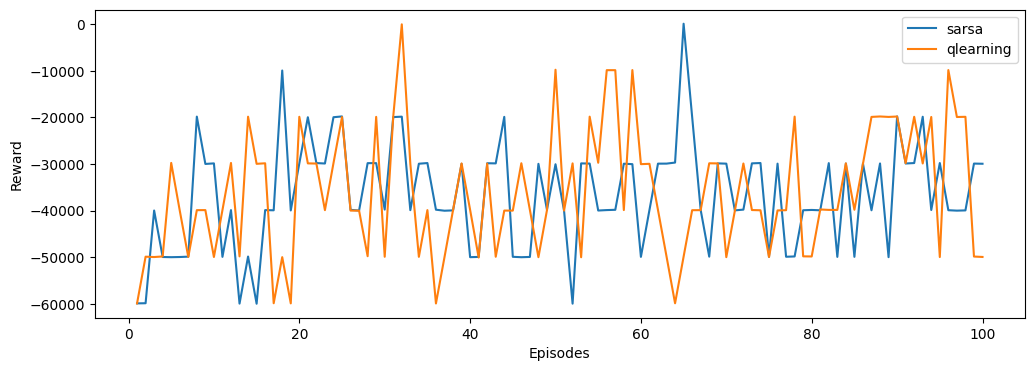

In [7]:
x=np.arange(1,101,1)
plt.figure(figsize=(12, 4))
plt.plot(x,ep1,label='sarsa')
plt.plot(x,ep2,label='qlearning')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.legend()
plt.show()